In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [53]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

In [54]:
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [55]:
train_dataset = train_datagen.flow_from_directory(
    directory='D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/train/',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    batch_size=64)

Found 3296 images belonging to 6 classes.


In [56]:
valid_dataset = valid_datagen.flow_from_directory(
    directory='D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/val/',
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    batch_size=64)

Found 173 images belonging to 6 classes.


In [57]:
test_dataset = test_datagen.flow_from_directory(
    directory='D:/Kuliah Semester 6/Jurnal/Materi/CNN/Split_dataset/test/',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64)

Found 888 images belonging to 6 classes.


In [58]:
# Load Base Model
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [59]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [60]:
# Building Model
model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),
    Dense(128, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(64, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [61]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [62]:
# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc'),
                  f1_score,
              ])

In [63]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [64]:
# Train Model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=21,
                    verbose=1,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 6755s 131s/step - accuracy: 0.8077 - auc: 0.5839 - f1_score: 0.1397 - loss: 2.0907 - precision: 0.2792 - recall: 0.0932 - val_accuracy: 0.7245 - val_auc: 0.5215 - val_f1_score: 0.1826 - val_loss: 9.6005 - val_precision: 0.1734 - val_recall: 0.1734 - learning_rate: 0.0010
Epoch 2/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 0.8527 - auc: 0.7907 - f1_score: 0.3242 - loss: 1.3975 - precision: 0.6875 - recall: 0.2129 - val_accuracy: 0.8545 - val_auc: 0.7874 - val_f1_score: 0.5382 - val_loss: 2.6956 - val_precision: 0.5688 - val_recall: 0.5260 - learning_rate: 0.0010
Epoch 3/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 446s 8s/step - accuracy: 0.8822 - auc: 0.8917 - f1_score: 0.5047 - loss: 1.0759 - precision: 0.8387 - recall: 0.3634 - val_accuracy: 0.8430 - val_auc: 0.8138 - val_f1_score: 0.5088 - val_loss: 2.1397 - val_precision: 0.5309 - val_recall: 0.4971 - learning_rate: 0.0010
Epoch 4/21
52/52 ━━━━━━━━━━━━━━━━━━━━ 508s 9s/step - accuracy: 0.9058 - auc:

In [65]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt 
def Train_Val_plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle("VISUALIZE THE PERFORMANCE MATRICS")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend(['training', 'validation'])
    plt.show()


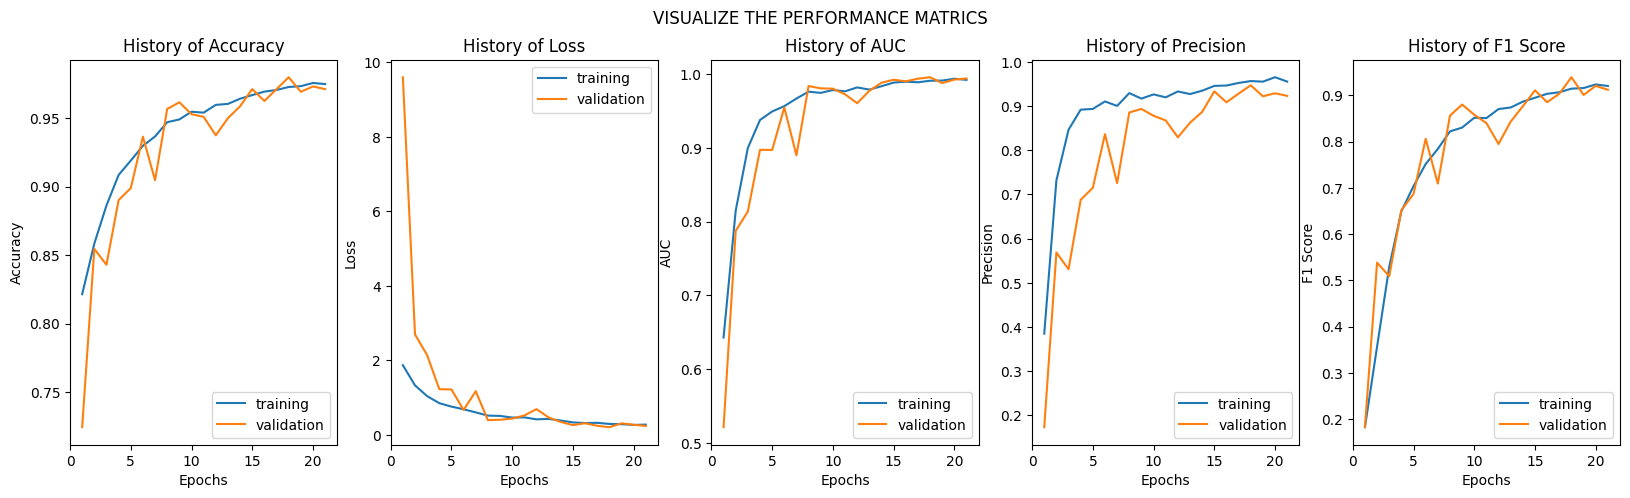

In [66]:
Train_Val_plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [67]:
# Evaluating model on the test dataset
scores = model.evaluate(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1 Score = ", scores[5])


14/14 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.9728 - auc: 0.9906 - f1_score: 0.9178 - loss: 0.2720 - precision: 0.9241 - recall: 0.9114
Accuracy =  0.9776651859283447
Precision =  0.937428891658783
Recall =  0.9279279112815857
AUC =  0.9928821921348572
F1 Score =  0.9330105781555176


In [68]:
# Saving the model
model.save('mobilenetv2_NEW21Epoch.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions shape: (1, 6)
Predicted class: Gogos


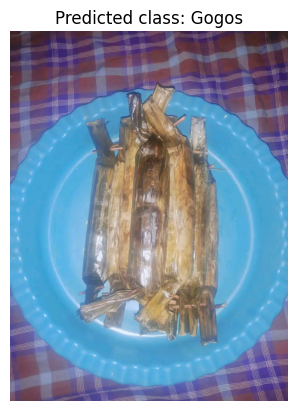

In [69]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Load the custom MobileNetV2 model
model = load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\Codingan\mobilenetv2_NEW25Epoch.h5")

# Define the class names
class_names = ['Buras', 'Dangkot', 'Gogos', 'Kapurung', 'Sokko', 'Sop Konro']

# Define the path to your image
image_path = r"E:\Dataset\Gogos\1715183308117.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran dengan ukuran input model Anda
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make prediction
preds = model.predict(x)

# Check the shape of the predictions
print("Predictions shape:", preds.shape)

# Get the index of the highest probability prediction
pred_index = np.argmax(preds)

# Initialize the predicted class variable
predicted_class = "Predicted index is out of range"

# Check if pred_index is within the range of class_names
if pred_index < len(class_names):
    # Get the predicted class label
    predicted_class = class_names[pred_index]

# Print the predicted class label
print("Predicted class:", predicted_class)

# Display the image along with the predicted class
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()